In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""
fpi = 10

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 1y6ktp79


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-1y6ktp79:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                           | 0/330 [00:00<?, ?it/s]

  0%|▍                                                                                                                                  | 1/330 [00:01<06:57,  1.27s/it]

  1%|▊                                                                                                                                  | 2/330 [00:01<03:34,  1.53it/s]

  1%|█▏                                                                                                                                 | 3/330 [00:01<02:29,  2.19it/s]

  1%|█▌                                                                                                                                 | 4/330 [00:01<01:58,  2.75it/s]

  2%|█▉                                                                                                                                 | 5/330 [00:02<01:41,  3.21it/s]

  2%|██▍                                                                                                                                | 6/330 [00:02<01:31,  3.56it/s]

  2%|██▊                                                                                                                                | 7/330 [00:02<01:24,  3.83it/s]

  2%|███▏                                                                                                                               | 8/330 [00:02<01:20,  4.02it/s]

  3%|███▌                                                                                                                               | 9/330 [00:03<01:16,  4.17it/s]

  3%|███▉                                                                                                                              | 10/330 [00:03<01:14,  4.27it/s]

  3%|████▎                                                                                                                             | 11/330 [00:03<01:13,  4.35it/s]

  4%|████▋                                                                                                                             | 12/330 [00:03<01:12,  4.40it/s]

  4%|█████                                                                                                                             | 13/330 [00:03<01:11,  4.44it/s]

  4%|█████▌                                                                                                                            | 14/330 [00:04<01:10,  4.47it/s]

  5%|█████▉                                                                                                                            | 15/330 [00:04<01:10,  4.48it/s]

  5%|██████▎                                                                                                                           | 16/330 [00:04<01:09,  4.50it/s]

  5%|██████▋                                                                                                                           | 17/330 [00:04<01:09,  4.51it/s]

  5%|███████                                                                                                                           | 18/330 [00:05<01:09,  4.51it/s]

  6%|███████▍                                                                                                                          | 19/330 [00:05<01:08,  4.52it/s]

  6%|███████▉                                                                                                                          | 20/330 [00:05<01:08,  4.52it/s]

  6%|████████▎                                                                                                                         | 21/330 [00:05<01:08,  4.52it/s]

  7%|████████▋                                                                                                                         | 22/330 [00:05<01:08,  4.52it/s]

  7%|█████████                                                                                                                         | 23/330 [00:06<01:07,  4.52it/s]

  7%|█████████▍                                                                                                                        | 24/330 [00:06<01:07,  4.53it/s]

  8%|█████████▊                                                                                                                        | 25/330 [00:06<01:07,  4.53it/s]

  8%|██████████▏                                                                                                                       | 26/330 [00:06<01:07,  4.53it/s]

  8%|██████████▋                                                                                                                       | 27/330 [00:07<01:06,  4.53it/s]

  8%|███████████                                                                                                                       | 28/330 [00:07<01:06,  4.53it/s]

  9%|███████████▍                                                                                                                      | 29/330 [00:07<01:06,  4.53it/s]

  9%|███████████▊                                                                                                                      | 30/330 [00:07<01:06,  4.53it/s]

  9%|████████████▏                                                                                                                     | 31/330 [00:07<01:06,  4.53it/s]

 10%|████████████▌                                                                                                                     | 32/330 [00:08<01:05,  4.53it/s]

 10%|█████████████                                                                                                                     | 33/330 [00:08<01:05,  4.53it/s]

 10%|█████████████▍                                                                                                                    | 34/330 [00:08<01:05,  4.53it/s]

 11%|█████████████▊                                                                                                                    | 35/330 [00:08<01:05,  4.53it/s]

 11%|██████████████▏                                                                                                                   | 36/330 [00:09<01:04,  4.53it/s]

 11%|██████████████▌                                                                                                                   | 37/330 [00:09<01:04,  4.53it/s]

 12%|██████████████▉                                                                                                                   | 38/330 [00:09<01:04,  4.53it/s]

 12%|███████████████▎                                                                                                                  | 39/330 [00:09<01:04,  4.53it/s]

 12%|███████████████▊                                                                                                                  | 40/330 [00:09<01:04,  4.53it/s]

 12%|████████████████▏                                                                                                                 | 41/330 [00:10<01:03,  4.53it/s]

 13%|████████████████▌                                                                                                                 | 42/330 [00:10<01:03,  4.53it/s]

 13%|████████████████▉                                                                                                                 | 43/330 [00:10<01:03,  4.53it/s]

 13%|█████████████████▎                                                                                                                | 44/330 [00:10<01:03,  4.53it/s]

 14%|█████████████████▋                                                                                                                | 45/330 [00:10<01:02,  4.53it/s]

 14%|██████████████████                                                                                                                | 46/330 [00:11<01:02,  4.53it/s]

 14%|██████████████████▌                                                                                                               | 47/330 [00:11<01:02,  4.53it/s]

 15%|██████████████████▉                                                                                                               | 48/330 [00:11<01:02,  4.53it/s]

 15%|███████████████████▎                                                                                                              | 49/330 [00:11<01:02,  4.53it/s]

 15%|███████████████████▋                                                                                                              | 50/330 [00:12<01:01,  4.53it/s]

 15%|████████████████████                                                                                                              | 51/330 [00:12<01:01,  4.53it/s]

 16%|████████████████████▍                                                                                                             | 52/330 [00:12<01:01,  4.53it/s]

 16%|████████████████████▉                                                                                                             | 53/330 [00:12<01:01,  4.53it/s]

 16%|█████████████████████▎                                                                                                            | 54/330 [00:12<01:00,  4.53it/s]

 17%|█████████████████████▋                                                                                                            | 55/330 [00:13<01:00,  4.53it/s]

 17%|██████████████████████                                                                                                            | 56/330 [00:13<01:00,  4.53it/s]

 17%|██████████████████████▍                                                                                                           | 57/330 [00:13<01:00,  4.52it/s]

 18%|██████████████████████▊                                                                                                           | 58/330 [00:13<01:00,  4.53it/s]

 18%|███████████████████████▏                                                                                                          | 59/330 [00:14<00:59,  4.53it/s]

 18%|███████████████████████▋                                                                                                          | 60/330 [00:14<00:59,  4.53it/s]

 18%|████████████████████████                                                                                                          | 61/330 [00:14<00:59,  4.53it/s]

 19%|████████████████████████▍                                                                                                         | 62/330 [00:14<00:59,  4.53it/s]

 19%|████████████████████████▊                                                                                                         | 63/330 [00:14<00:58,  4.53it/s]

 19%|█████████████████████████▏                                                                                                        | 64/330 [00:15<00:58,  4.53it/s]

 20%|█████████████████████████▌                                                                                                        | 65/330 [00:15<00:58,  4.52it/s]

 20%|██████████████████████████                                                                                                        | 66/330 [00:15<00:58,  4.52it/s]

 20%|██████████████████████████▍                                                                                                       | 67/330 [00:15<00:58,  4.53it/s]

 21%|██████████████████████████▊                                                                                                       | 68/330 [00:16<00:57,  4.53it/s]

 21%|███████████████████████████▏                                                                                                      | 69/330 [00:16<00:57,  4.53it/s]

 21%|███████████████████████████▌                                                                                                      | 70/330 [00:16<00:57,  4.53it/s]

 22%|███████████████████████████▉                                                                                                      | 71/330 [00:16<00:57,  4.53it/s]

 22%|████████████████████████████▎                                                                                                     | 72/330 [00:16<00:56,  4.53it/s]

 22%|████████████████████████████▊                                                                                                     | 73/330 [00:17<00:56,  4.53it/s]

 22%|█████████████████████████████▏                                                                                                    | 74/330 [00:17<00:56,  4.53it/s]

 23%|█████████████████████████████▌                                                                                                    | 75/330 [00:17<00:56,  4.53it/s]

 23%|█████████████████████████████▉                                                                                                    | 76/330 [00:17<00:56,  4.53it/s]

 23%|██████████████████████████████▎                                                                                                   | 77/330 [00:18<00:55,  4.53it/s]

 24%|██████████████████████████████▋                                                                                                   | 78/330 [00:18<00:55,  4.53it/s]

 24%|███████████████████████████████                                                                                                   | 79/330 [00:18<00:55,  4.53it/s]

 24%|███████████████████████████████▌                                                                                                  | 80/330 [00:18<00:55,  4.53it/s]

 25%|███████████████████████████████▉                                                                                                  | 81/330 [00:18<00:54,  4.53it/s]

 25%|████████████████████████████████▎                                                                                                 | 82/330 [00:19<00:54,  4.53it/s]

 25%|████████████████████████████████▋                                                                                                 | 83/330 [00:19<00:54,  4.53it/s]

 25%|█████████████████████████████████                                                                                                 | 84/330 [00:19<00:54,  4.53it/s]

 26%|█████████████████████████████████▍                                                                                                | 85/330 [00:19<00:54,  4.53it/s]

 26%|█████████████████████████████████▉                                                                                                | 86/330 [00:20<00:53,  4.53it/s]

 26%|██████████████████████████████████▎                                                                                               | 87/330 [00:20<00:53,  4.53it/s]

 27%|██████████████████████████████████▋                                                                                               | 88/330 [00:20<00:53,  4.53it/s]

 27%|███████████████████████████████████                                                                                               | 89/330 [00:20<00:53,  4.53it/s]

 27%|███████████████████████████████████▍                                                                                              | 90/330 [00:20<00:53,  4.53it/s]

 28%|███████████████████████████████████▊                                                                                              | 91/330 [00:21<00:52,  4.53it/s]

 28%|████████████████████████████████████▏                                                                                             | 92/330 [00:21<00:52,  4.53it/s]

 28%|████████████████████████████████████▋                                                                                             | 93/330 [00:21<00:52,  4.53it/s]

 28%|█████████████████████████████████████                                                                                             | 94/330 [00:21<00:52,  4.53it/s]

 29%|█████████████████████████████████████▍                                                                                            | 95/330 [00:22<00:51,  4.53it/s]

 29%|█████████████████████████████████████▊                                                                                            | 96/330 [00:22<00:51,  4.53it/s]

 29%|██████████████████████████████████████▏                                                                                           | 97/330 [00:22<00:51,  4.53it/s]

 30%|██████████████████████████████████████▌                                                                                           | 98/330 [00:22<00:51,  4.52it/s]

 30%|███████████████████████████████████████                                                                                           | 99/330 [00:22<00:51,  4.53it/s]

 30%|███████████████████████████████████████                                                                                          | 100/330 [00:23<00:50,  4.53it/s]

 31%|███████████████████████████████████████▍                                                                                         | 101/330 [00:23<00:50,  4.53it/s]

 31%|███████████████████████████████████████▊                                                                                         | 102/330 [00:23<00:50,  4.53it/s]

 31%|████████████████████████████████████████▎                                                                                        | 103/330 [00:23<00:50,  4.53it/s]

 32%|████████████████████████████████████████▋                                                                                        | 104/330 [00:24<00:49,  4.53it/s]

 32%|█████████████████████████████████████████                                                                                        | 105/330 [00:24<00:49,  4.53it/s]

 32%|█████████████████████████████████████████▍                                                                                       | 106/330 [00:24<00:49,  4.53it/s]

 32%|█████████████████████████████████████████▊                                                                                       | 107/330 [00:24<00:49,  4.53it/s]

 33%|██████████████████████████████████████████▏                                                                                      | 108/330 [00:24<00:49,  4.53it/s]

 33%|██████████████████████████████████████████▌                                                                                      | 109/330 [00:25<00:48,  4.53it/s]

 33%|███████████████████████████████████████████                                                                                      | 110/330 [00:25<00:48,  4.53it/s]

 34%|███████████████████████████████████████████▍                                                                                     | 111/330 [00:25<00:48,  4.53it/s]

 34%|███████████████████████████████████████████▊                                                                                     | 112/330 [00:25<00:48,  4.53it/s]

 34%|████████████████████████████████████████████▏                                                                                    | 113/330 [00:26<00:47,  4.53it/s]

 35%|████████████████████████████████████████████▌                                                                                    | 114/330 [00:26<00:47,  4.53it/s]

 35%|████████████████████████████████████████████▉                                                                                    | 115/330 [00:26<00:47,  4.53it/s]

 35%|█████████████████████████████████████████████▎                                                                                   | 116/330 [00:26<00:47,  4.53it/s]

 35%|█████████████████████████████████████████████▋                                                                                   | 117/330 [00:26<00:47,  4.53it/s]

 36%|██████████████████████████████████████████████▏                                                                                  | 118/330 [00:27<00:46,  4.53it/s]

 36%|██████████████████████████████████████████████▌                                                                                  | 119/330 [00:27<00:46,  4.53it/s]

 36%|██████████████████████████████████████████████▉                                                                                  | 120/330 [00:27<00:46,  4.52it/s]

 37%|███████████████████████████████████████████████▎                                                                                 | 121/330 [00:27<00:46,  4.52it/s]

 37%|███████████████████████████████████████████████▋                                                                                 | 122/330 [00:28<00:45,  4.52it/s]

 37%|████████████████████████████████████████████████                                                                                 | 123/330 [00:28<00:45,  4.52it/s]

 38%|████████████████████████████████████████████████▍                                                                                | 124/330 [00:28<00:45,  4.53it/s]

 38%|████████████████████████████████████████████████▊                                                                                | 125/330 [00:28<00:45,  4.53it/s]

 38%|█████████████████████████████████████████████████▎                                                                               | 126/330 [00:28<00:45,  4.53it/s]

 38%|█████████████████████████████████████████████████▋                                                                               | 127/330 [00:29<00:44,  4.53it/s]

 39%|██████████████████████████████████████████████████                                                                               | 128/330 [00:29<00:44,  4.53it/s]

 39%|██████████████████████████████████████████████████▍                                                                              | 129/330 [00:29<00:44,  4.53it/s]

 39%|██████████████████████████████████████████████████▊                                                                              | 130/330 [00:29<00:44,  4.53it/s]

 40%|███████████████████████████████████████████████████▏                                                                             | 131/330 [00:29<00:43,  4.53it/s]

 40%|███████████████████████████████████████████████████▌                                                                             | 132/330 [00:30<00:43,  4.53it/s]

 40%|███████████████████████████████████████████████████▉                                                                             | 133/330 [00:30<00:43,  4.53it/s]

 41%|████████████████████████████████████████████████████▍                                                                            | 134/330 [00:30<00:43,  4.53it/s]

 41%|████████████████████████████████████████████████████▊                                                                            | 135/330 [00:30<00:43,  4.52it/s]

 41%|█████████████████████████████████████████████████████▏                                                                           | 136/330 [00:31<00:42,  4.52it/s]

 42%|█████████████████████████████████████████████████████▌                                                                           | 137/330 [00:31<00:42,  4.52it/s]

 42%|█████████████████████████████████████████████████████▉                                                                           | 138/330 [00:31<00:42,  4.53it/s]

 42%|██████████████████████████████████████████████████████▎                                                                          | 139/330 [00:31<00:42,  4.53it/s]

 42%|██████████████████████████████████████████████████████▋                                                                          | 140/330 [00:31<00:41,  4.53it/s]

 43%|███████████████████████████████████████████████████████                                                                          | 141/330 [00:32<00:41,  4.53it/s]

 43%|███████████████████████████████████████████████████████▌                                                                         | 142/330 [00:32<00:41,  4.53it/s]

 43%|███████████████████████████████████████████████████████▉                                                                         | 143/330 [00:32<00:41,  4.53it/s]

 44%|████████████████████████████████████████████████████████▎                                                                        | 144/330 [00:32<00:41,  4.53it/s]

 44%|████████████████████████████████████████████████████████▋                                                                        | 145/330 [00:33<00:40,  4.53it/s]

 44%|█████████████████████████████████████████████████████████                                                                        | 146/330 [00:33<00:40,  4.53it/s]

 45%|█████████████████████████████████████████████████████████▍                                                                       | 147/330 [00:33<00:40,  4.52it/s]

 45%|█████████████████████████████████████████████████████████▊                                                                       | 148/330 [00:33<00:40,  4.53it/s]

 45%|██████████████████████████████████████████████████████████▏                                                                      | 149/330 [00:33<00:39,  4.53it/s]

 45%|██████████████████████████████████████████████████████████▋                                                                      | 150/330 [00:34<00:39,  4.53it/s]

 46%|███████████████████████████████████████████████████████████                                                                      | 151/330 [00:34<00:39,  4.53it/s]

 46%|███████████████████████████████████████████████████████████▍                                                                     | 152/330 [00:34<00:39,  4.53it/s]

 46%|███████████████████████████████████████████████████████████▊                                                                     | 153/330 [00:34<00:39,  4.53it/s]

 47%|████████████████████████████████████████████████████████████▏                                                                    | 154/330 [00:35<00:38,  4.52it/s]

 47%|████████████████████████████████████████████████████████████▌                                                                    | 155/330 [00:35<00:38,  4.52it/s]

 47%|████████████████████████████████████████████████████████████▉                                                                    | 156/330 [00:35<00:38,  4.52it/s]

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 157/330 [00:35<00:38,  4.52it/s]

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 158/330 [00:35<00:38,  4.52it/s]

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 159/330 [00:36<00:37,  4.52it/s]

 48%|██████████████████████████████████████████████████████████████▌                                                                  | 160/330 [00:36<00:37,  4.52it/s]

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 161/330 [00:36<00:37,  4.53it/s]

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 162/330 [00:36<00:37,  4.53it/s]

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 163/330 [00:37<00:36,  4.52it/s]

 50%|████████████████████████████████████████████████████████████████                                                                 | 164/330 [00:37<00:36,  4.53it/s]

 50%|████████████████████████████████████████████████████████████████▌                                                                | 165/330 [00:37<00:36,  4.53it/s]

 50%|████████████████████████████████████████████████████████████████▉                                                                | 166/330 [00:37<00:36,  4.53it/s]

 51%|█████████████████████████████████████████████████████████████████▎                                                               | 167/330 [00:37<00:36,  4.53it/s]

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 168/330 [00:38<00:35,  4.53it/s]

 51%|██████████████████████████████████████████████████████████████████                                                               | 169/330 [00:38<00:35,  4.53it/s]

 52%|██████████████████████████████████████████████████████████████████▍                                                              | 170/330 [00:38<00:35,  4.53it/s]

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 171/330 [00:38<00:35,  4.53it/s]

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 172/330 [00:39<00:34,  4.53it/s]

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 173/330 [00:39<00:34,  4.53it/s]

 53%|████████████████████████████████████████████████████████████████████                                                             | 174/330 [00:39<00:34,  4.52it/s]

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 175/330 [00:39<00:34,  4.52it/s]

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 176/330 [00:39<00:34,  4.52it/s]

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 177/330 [00:40<00:33,  4.53it/s]

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 178/330 [00:40<00:33,  4.53it/s]

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 179/330 [00:40<00:33,  4.53it/s]

 55%|██████████████████████████████████████████████████████████████████████▎                                                          | 180/330 [00:40<00:33,  4.53it/s]

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 181/330 [00:41<00:32,  4.53it/s]

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 182/330 [00:41<00:32,  4.53it/s]

 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 183/330 [00:41<00:32,  4.53it/s]

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 184/330 [00:41<00:32,  4.53it/s]

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 185/330 [00:41<00:32,  4.53it/s]

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 186/330 [00:42<00:31,  4.53it/s]

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 187/330 [00:42<00:31,  4.53it/s]

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 188/330 [00:42<00:31,  4.53it/s]

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 189/330 [00:42<00:31,  4.53it/s]

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 190/330 [00:43<00:30,  4.53it/s]

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 191/330 [00:43<00:30,  4.52it/s]

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 192/330 [00:43<00:30,  4.52it/s]

 58%|███████████████████████████████████████████████████████████████████████████▍                                                     | 193/330 [00:43<00:30,  4.53it/s]

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 194/330 [00:43<00:30,  4.53it/s]

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 195/330 [00:44<00:29,  4.53it/s]

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 196/330 [00:44<00:29,  4.52it/s]

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 197/330 [00:44<00:29,  4.52it/s]

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 198/330 [00:44<00:29,  4.52it/s]

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 199/330 [00:45<00:28,  4.52it/s]

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 200/330 [00:45<00:28,  4.52it/s]

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 201/330 [00:45<00:28,  4.52it/s]

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 202/330 [00:45<00:28,  4.52it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 203/330 [00:45<00:28,  4.52it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 204/330 [00:46<00:27,  4.52it/s]

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 205/330 [00:46<00:27,  4.52it/s]

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 206/330 [00:46<00:27,  4.53it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 207/330 [00:46<00:27,  4.52it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 208/330 [00:47<00:26,  4.52it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 209/330 [00:47<00:26,  4.53it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 210/330 [00:47<00:26,  4.53it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 211/330 [00:47<00:26,  4.53it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 212/330 [00:47<00:26,  4.53it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 213/330 [00:48<00:25,  4.53it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 214/330 [00:48<00:25,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 215/330 [00:48<00:25,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 216/330 [00:48<00:25,  4.53it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 217/330 [00:48<00:24,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 218/330 [00:49<00:24,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 219/330 [00:49<00:24,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 220/330 [00:49<00:24,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 221/330 [00:49<00:24,  4.52it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 222/330 [00:50<00:23,  4.52it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 223/330 [00:50<00:23,  4.52it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 224/330 [00:50<00:23,  4.52it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 225/330 [00:50<00:23,  4.53it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 226/330 [00:50<00:22,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                        | 227/330 [00:51<00:22,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                       | 228/330 [00:51<00:22,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                       | 229/330 [00:51<00:22,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                       | 230/330 [00:51<00:22,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 231/330 [00:52<00:21,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                      | 232/330 [00:52<00:21,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 233/330 [00:52<00:21,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 234/330 [00:52<00:21,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                     | 235/330 [00:52<00:20,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 236/330 [00:53<00:20,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 237/330 [00:53<00:20,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 238/330 [00:53<00:20,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 239/330 [00:53<00:20,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 240/330 [00:54<00:19,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 241/330 [00:54<00:19,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 242/330 [00:54<00:19,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 243/330 [00:54<00:19,  4.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 244/330 [00:54<00:19,  4.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 245/330 [00:55<00:18,  4.53it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 246/330 [00:55<00:18,  4.53it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 247/330 [00:55<00:18,  4.52it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 248/330 [00:55<00:18,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 249/330 [00:56<00:17,  4.52it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 250/330 [00:56<00:17,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 251/330 [00:56<00:17,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 252/330 [00:56<00:17,  4.52it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 253/330 [00:56<00:17,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 254/330 [00:57<00:16,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 255/330 [00:57<00:16,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                             | 256/330 [00:57<00:16,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 257/330 [00:57<00:16,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 258/330 [00:58<00:15,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 259/330 [00:58<00:15,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 260/330 [00:58<00:15,  4.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 261/330 [00:58<00:15,  4.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 262/330 [00:58<00:15,  4.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 263/330 [00:59<00:14,  4.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 264/330 [00:59<00:14,  4.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 265/330 [00:59<00:14,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 266/330 [00:59<00:14,  4.53it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 267/330 [01:00<00:13,  4.53it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 268/330 [01:00<00:13,  4.53it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 269/330 [01:00<00:13,  4.53it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 270/330 [01:00<00:13,  4.53it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 271/330 [01:00<00:13,  4.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 272/330 [01:01<00:12,  4.53it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 273/330 [01:01<00:12,  4.53it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 274/330 [01:01<00:12,  4.53it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 275/330 [01:01<00:12,  4.52it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 276/330 [01:02<00:11,  4.52it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 277/330 [01:02<00:11,  4.52it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 278/330 [01:02<00:11,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 279/330 [01:02<00:11,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 280/330 [01:02<00:11,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 281/330 [01:03<00:10,  4.52it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 282/330 [01:03<00:10,  4.52it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 283/330 [01:03<00:10,  4.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 284/330 [01:03<00:10,  4.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 285/330 [01:04<00:09,  4.52it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 286/330 [01:04<00:09,  4.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 287/330 [01:04<00:09,  4.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 288/330 [01:04<00:09,  4.52it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 289/330 [01:04<00:09,  4.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 290/330 [01:05<00:08,  4.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 291/330 [01:05<00:08,  4.52it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 292/330 [01:05<00:08,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 293/330 [01:05<00:08,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 294/330 [01:06<00:07,  4.53it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 295/330 [01:06<00:07,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 296/330 [01:06<00:07,  4.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 297/330 [01:06<00:07,  4.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 298/330 [01:06<00:07,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 299/330 [01:07<00:06,  4.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 300/330 [01:07<00:06,  4.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 301/330 [01:07<00:06,  4.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 302/330 [01:07<00:06,  4.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 303/330 [01:07<00:05,  4.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 304/330 [01:08<00:05,  4.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 305/330 [01:08<00:05,  4.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 306/330 [01:08<00:05,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 307/330 [01:08<00:05,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 308/330 [01:09<00:04,  4.53it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 309/330 [01:09<00:04,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 310/330 [01:09<00:04,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 311/330 [01:09<00:04,  4.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 312/330 [01:09<00:03,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 313/330 [01:10<00:03,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 314/330 [01:10<00:03,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 315/330 [01:10<00:03,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 316/330 [01:10<00:03,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 317/330 [01:11<00:02,  4.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 318/330 [01:11<00:02,  4.52it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 319/330 [01:11<00:02,  4.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 320/330 [01:11<00:02,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 321/330 [01:11<00:01,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 322/330 [01:12<00:01,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 323/330 [01:12<00:01,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 324/330 [01:12<00:01,  4.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 325/330 [01:12<00:01,  4.52it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 326/330 [01:13<00:00,  4.52it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 327/330 [01:13<00:00,  4.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 328/330 [01:13<00:00,  4.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 329/330 [01:13<00:00,  4.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [01:13<00:00,  5.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [01:13<00:00,  4.47it/s]

train - OK


  0%|                                                                                                                                            | 0/42 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                | 1/42 [00:00<00:14,  2.90it/s]

  5%|██████▎                                                                                                                             | 2/42 [00:00<00:10,  3.67it/s]

  7%|█████████▍                                                                                                                          | 3/42 [00:00<00:09,  4.01it/s]

 10%|████████████▌                                                                                                                       | 4/42 [00:01<00:09,  4.20it/s]

 12%|███████████████▋                                                                                                                    | 5/42 [00:01<00:08,  4.31it/s]

 14%|██████████████████▊                                                                                                                 | 6/42 [00:01<00:08,  4.38it/s]

 17%|██████████████████████                                                                                                              | 7/42 [00:01<00:07,  4.42it/s]

 19%|█████████████████████████▏                                                                                                          | 8/42 [00:01<00:07,  4.46it/s]

 21%|████████████████████████████▎                                                                                                       | 9/42 [00:02<00:07,  4.48it/s]

 24%|███████████████████████████████▏                                                                                                   | 10/42 [00:02<00:07,  4.49it/s]

 26%|██████████████████████████████████▎                                                                                                | 11/42 [00:02<00:06,  4.50it/s]

 29%|█████████████████████████████████████▍                                                                                             | 12/42 [00:02<00:06,  4.51it/s]

 31%|████████████████████████████████████████▌                                                                                          | 13/42 [00:02<00:06,  4.51it/s]

 33%|███████████████████████████████████████████▋                                                                                       | 14/42 [00:03<00:06,  4.51it/s]

 36%|██████████████████████████████████████████████▊                                                                                    | 15/42 [00:03<00:05,  4.52it/s]

 38%|█████████████████████████████████████████████████▉                                                                                 | 16/42 [00:03<00:05,  4.52it/s]

 40%|█████████████████████████████████████████████████████                                                                              | 17/42 [00:03<00:05,  4.52it/s]

 43%|████████████████████████████████████████████████████████▏                                                                          | 18/42 [00:04<00:05,  4.52it/s]

 45%|███████████████████████████████████████████████████████████▎                                                                       | 19/42 [00:04<00:05,  4.52it/s]

 48%|██████████████████████████████████████████████████████████████▍                                                                    | 20/42 [00:04<00:04,  4.52it/s]

 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 21/42 [00:04<00:04,  4.52it/s]

 52%|████████████████████████████████████████████████████████████████████▌                                                              | 22/42 [00:04<00:04,  4.52it/s]

 55%|███████████████████████████████████████████████████████████████████████▋                                                           | 23/42 [00:05<00:04,  4.52it/s]

 57%|██████████████████████████████████████████████████████████████████████████▊                                                        | 24/42 [00:05<00:03,  4.52it/s]

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                     | 25/42 [00:05<00:03,  4.52it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████                                                  | 26/42 [00:05<00:03,  4.52it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████▏                                              | 27/42 [00:06<00:03,  4.52it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████▎                                           | 28/42 [00:06<00:03,  4.52it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████▍                                        | 29/42 [00:06<00:02,  4.52it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 30/42 [00:06<00:02,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 31/42 [00:06<00:02,  4.52it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 32/42 [00:07<00:02,  4.52it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 33/42 [00:07<00:01,  4.52it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 34/42 [00:07<00:01,  4.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 35/42 [00:07<00:01,  4.52it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 36/42 [00:08<00:01,  4.52it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 37/42 [00:08<00:01,  4.52it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 38/42 [00:08<00:00,  4.52it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 39/42 [00:08<00:00,  4.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 40/42 [00:08<00:00,  4.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 41/42 [00:09<00:00,  4.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:09<00:00,  4.51it/s]

val - OK


  0%|                                                                                                                                            | 0/23 [00:00<?, ?it/s]

  4%|█████▋                                                                                                                              | 1/23 [00:00<00:07,  2.81it/s]

  9%|███████████▍                                                                                                                        | 2/23 [00:00<00:05,  3.61it/s]

 13%|█████████████████▏                                                                                                                  | 3/23 [00:00<00:05,  3.97it/s]

 17%|██████████████████████▉                                                                                                             | 4/23 [00:01<00:04,  4.17it/s]

 22%|████████████████████████████▋                                                                                                       | 5/23 [00:01<00:04,  4.29it/s]

 26%|██████████████████████████████████▍                                                                                                 | 6/23 [00:01<00:03,  4.37it/s]

 30%|████████████████████████████████████████▏                                                                                           | 7/23 [00:01<00:03,  4.42it/s]

 35%|█████████████████████████████████████████████▉                                                                                      | 8/23 [00:01<00:03,  4.45it/s]

 39%|███████████████████████████████████████████████████▋                                                                                | 9/23 [00:02<00:03,  4.47it/s]

 43%|████████████████████████████████████████████████████████▉                                                                          | 10/23 [00:02<00:02,  4.49it/s]

 48%|██████████████████████████████████████████████████████████████▋                                                                    | 11/23 [00:02<00:02,  4.50it/s]

 52%|████████████████████████████████████████████████████████████████████▎                                                              | 12/23 [00:02<00:02,  4.50it/s]

 57%|██████████████████████████████████████████████████████████████████████████                                                         | 13/23 [00:03<00:02,  4.51it/s]

 61%|███████████████████████████████████████████████████████████████████████████████▋                                                   | 14/23 [00:03<00:01,  4.51it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████▍                                             | 15/23 [00:03<00:01,  4.51it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████▏                                       | 16/23 [00:03<00:01,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 17/23 [00:03<00:01,  4.52it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 18/23 [00:04<00:01,  4.52it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 19/23 [00:04<00:00,  4.52it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 20/23 [00:04<00:00,  4.51it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 21/23 [00:04<00:00,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 22/23 [00:05<00:00,  4.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.37it/s]

test InD - OK


  0%|                                                                                                                                           | 0/138 [00:00<?, ?it/s]

  1%|▉                                                                                                                                  | 1/138 [00:00<00:49,  2.79it/s]

  1%|█▉                                                                                                                                 | 2/138 [00:00<00:37,  3.59it/s]

  2%|██▊                                                                                                                                | 3/138 [00:00<00:34,  3.97it/s]

  3%|███▊                                                                                                                               | 4/138 [00:01<00:32,  4.17it/s]

  4%|████▋                                                                                                                              | 5/138 [00:01<00:31,  4.29it/s]

  4%|█████▋                                                                                                                             | 6/138 [00:01<00:30,  4.36it/s]

  5%|██████▋                                                                                                                            | 7/138 [00:01<00:29,  4.41it/s]

  6%|███████▌                                                                                                                           | 8/138 [00:01<00:29,  4.45it/s]

  7%|████████▌                                                                                                                          | 9/138 [00:02<00:28,  4.47it/s]

  7%|█████████▍                                                                                                                        | 10/138 [00:02<00:28,  4.48it/s]

  8%|██████████▎                                                                                                                       | 11/138 [00:02<00:28,  4.49it/s]

  9%|███████████▎                                                                                                                      | 12/138 [00:02<00:27,  4.50it/s]

  9%|████████████▏                                                                                                                     | 13/138 [00:03<00:27,  4.51it/s]

 10%|█████████████▏                                                                                                                    | 14/138 [00:03<00:27,  4.51it/s]

 11%|██████████████▏                                                                                                                   | 15/138 [00:03<00:27,  4.51it/s]

 12%|███████████████                                                                                                                   | 16/138 [00:03<00:27,  4.51it/s]

 12%|████████████████                                                                                                                  | 17/138 [00:03<00:26,  4.52it/s]

 13%|████████████████▉                                                                                                                 | 18/138 [00:04<00:26,  4.52it/s]

 14%|█████████████████▉                                                                                                                | 19/138 [00:04<00:26,  4.52it/s]

 14%|██████████████████▊                                                                                                               | 20/138 [00:04<00:26,  4.52it/s]

 15%|███████████████████▊                                                                                                              | 21/138 [00:04<00:25,  4.52it/s]

 16%|████████████████████▋                                                                                                             | 22/138 [00:05<00:25,  4.52it/s]

 17%|█████████████████████▋                                                                                                            | 23/138 [00:05<00:25,  4.52it/s]

 17%|██████████████████████▌                                                                                                           | 24/138 [00:05<00:25,  4.52it/s]

 18%|███████████████████████▌                                                                                                          | 25/138 [00:05<00:25,  4.52it/s]

 19%|████████████████████████▍                                                                                                         | 26/138 [00:05<00:24,  4.52it/s]

 20%|█████████████████████████▍                                                                                                        | 27/138 [00:06<00:24,  4.52it/s]

 20%|██████████████████████████▍                                                                                                       | 28/138 [00:06<00:24,  4.52it/s]

 21%|███████████████████████████▎                                                                                                      | 29/138 [00:06<00:24,  4.52it/s]

 22%|████████████████████████████▎                                                                                                     | 30/138 [00:06<00:23,  4.52it/s]

 22%|█████████████████████████████▏                                                                                                    | 31/138 [00:06<00:23,  4.52it/s]

 23%|██████████████████████████████▏                                                                                                   | 32/138 [00:07<00:23,  4.52it/s]

 24%|███████████████████████████████                                                                                                   | 33/138 [00:07<00:23,  4.52it/s]

 25%|████████████████████████████████                                                                                                  | 34/138 [00:07<00:23,  4.52it/s]

 25%|████████████████████████████████▉                                                                                                 | 35/138 [00:07<00:22,  4.52it/s]

 26%|█████████████████████████████████▉                                                                                                | 36/138 [00:08<00:22,  4.52it/s]

 27%|██████████████████████████████████▊                                                                                               | 37/138 [00:08<00:22,  4.52it/s]

 28%|███████████████████████████████████▊                                                                                              | 38/138 [00:08<00:22,  4.52it/s]

 28%|████████████████████████████████████▋                                                                                             | 39/138 [00:08<00:21,  4.52it/s]

 29%|█████████████████████████████████████▋                                                                                            | 40/138 [00:08<00:21,  4.52it/s]

 30%|██████████████████████████████████████▌                                                                                           | 41/138 [00:09<00:21,  4.52it/s]

 30%|███████████████████████████████████████▌                                                                                          | 42/138 [00:09<00:21,  4.52it/s]

 31%|████████████████████████████████████████▌                                                                                         | 43/138 [00:09<00:21,  4.52it/s]

 32%|█████████████████████████████████████████▍                                                                                        | 44/138 [00:09<00:20,  4.52it/s]

 33%|██████████████████████████████████████████▍                                                                                       | 45/138 [00:10<00:20,  4.52it/s]

 33%|███████████████████████████████████████████▎                                                                                      | 46/138 [00:10<00:20,  4.52it/s]

 34%|████████████████████████████████████████████▎                                                                                     | 47/138 [00:10<00:20,  4.52it/s]

 35%|█████████████████████████████████████████████▏                                                                                    | 48/138 [00:10<00:19,  4.52it/s]

 36%|██████████████████████████████████████████████▏                                                                                   | 49/138 [00:10<00:19,  4.52it/s]

 36%|███████████████████████████████████████████████                                                                                   | 50/138 [00:11<00:19,  4.52it/s]

 37%|████████████████████████████████████████████████                                                                                  | 51/138 [00:11<00:19,  4.52it/s]

 38%|████████████████████████████████████████████████▉                                                                                 | 52/138 [00:11<00:19,  4.52it/s]

 38%|█████████████████████████████████████████████████▉                                                                                | 53/138 [00:11<00:18,  4.52it/s]

 39%|██████████████████████████████████████████████████▊                                                                               | 54/138 [00:12<00:18,  4.52it/s]

 40%|███████████████████████████████████████████████████▊                                                                              | 55/138 [00:12<00:18,  4.52it/s]

 41%|████████████████████████████████████████████████████▊                                                                             | 56/138 [00:12<00:18,  4.52it/s]

 41%|█████████████████████████████████████████████████████▋                                                                            | 57/138 [00:12<00:17,  4.52it/s]

 42%|██████████████████████████████████████████████████████▋                                                                           | 58/138 [00:12<00:17,  4.52it/s]

 43%|███████████████████████████████████████████████████████▌                                                                          | 59/138 [00:13<00:17,  4.52it/s]

 43%|████████████████████████████████████████████████████████▌                                                                         | 60/138 [00:13<00:17,  4.52it/s]

 44%|█████████████████████████████████████████████████████████▍                                                                        | 61/138 [00:13<00:17,  4.52it/s]

 45%|██████████████████████████████████████████████████████████▍                                                                       | 62/138 [00:13<00:16,  4.52it/s]

 46%|███████████████████████████████████████████████████████████▎                                                                      | 63/138 [00:14<00:16,  4.52it/s]

 46%|████████████████████████████████████████████████████████████▎                                                                     | 64/138 [00:14<00:16,  4.52it/s]

 47%|█████████████████████████████████████████████████████████████▏                                                                    | 65/138 [00:14<00:16,  4.52it/s]

 48%|██████████████████████████████████████████████████████████████▏                                                                   | 66/138 [00:14<00:15,  4.52it/s]

 49%|███████████████████████████████████████████████████████████████                                                                   | 67/138 [00:14<00:15,  4.52it/s]

 49%|████████████████████████████████████████████████████████████████                                                                  | 68/138 [00:15<00:15,  4.52it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 69/138 [00:15<00:15,  4.52it/s]

 51%|█████████████████████████████████████████████████████████████████▉                                                                | 70/138 [00:15<00:15,  4.52it/s]

 51%|██████████████████████████████████████████████████████████████████▉                                                               | 71/138 [00:15<00:14,  4.52it/s]

 52%|███████████████████████████████████████████████████████████████████▊                                                              | 72/138 [00:16<00:14,  4.52it/s]

 53%|████████████████████████████████████████████████████████████████████▊                                                             | 73/138 [00:16<00:14,  4.52it/s]

 54%|█████████████████████████████████████████████████████████████████████▋                                                            | 74/138 [00:16<00:14,  4.52it/s]

 54%|██████████████████████████████████████████████████████████████████████▋                                                           | 75/138 [00:16<00:13,  4.52it/s]

 55%|███████████████████████████████████████████████████████████████████████▌                                                          | 76/138 [00:16<00:13,  4.52it/s]

 56%|████████████████████████████████████████████████████████████████████████▌                                                         | 77/138 [00:17<00:13,  4.52it/s]

 57%|█████████████████████████████████████████████████████████████████████████▍                                                        | 78/138 [00:17<00:13,  4.52it/s]

 57%|██████████████████████████████████████████████████████████████████████████▍                                                       | 79/138 [00:17<00:13,  4.52it/s]

 58%|███████████████████████████████████████████████████████████████████████████▎                                                      | 80/138 [00:17<00:12,  4.52it/s]

 59%|████████████████████████████████████████████████████████████████████████████▎                                                     | 81/138 [00:18<00:12,  4.52it/s]

 59%|█████████████████████████████████████████████████████████████████████████████▏                                                    | 82/138 [00:18<00:12,  4.52it/s]

 60%|██████████████████████████████████████████████████████████████████████████████▏                                                   | 83/138 [00:18<00:12,  4.52it/s]

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                  | 84/138 [00:18<00:11,  4.52it/s]

 62%|████████████████████████████████████████████████████████████████████████████████                                                  | 85/138 [00:18<00:11,  4.52it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████                                                 | 86/138 [00:19<00:11,  4.52it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                                | 87/138 [00:19<00:11,  4.52it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                               | 88/138 [00:19<00:11,  4.52it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████▊                                              | 89/138 [00:19<00:10,  4.52it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████▊                                             | 90/138 [00:20<00:10,  4.52it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                            | 91/138 [00:20<00:10,  4.52it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                           | 92/138 [00:20<00:10,  4.52it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████▌                                          | 93/138 [00:20<00:09,  4.52it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████▌                                         | 94/138 [00:20<00:09,  4.52it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████▍                                        | 95/138 [00:21<00:09,  4.52it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████▍                                       | 96/138 [00:21<00:09,  4.52it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████▍                                      | 97/138 [00:21<00:09,  4.52it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 98/138 [00:21<00:08,  4.52it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 99/138 [00:22<00:08,  4.52it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 100/138 [00:22<00:08,  4.52it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 101/138 [00:22<00:08,  4.52it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 102/138 [00:22<00:07,  4.52it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 103/138 [00:22<00:07,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 104/138 [00:23<00:07,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 105/138 [00:23<00:07,  4.52it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                              | 106/138 [00:23<00:07,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                             | 107/138 [00:23<00:06,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 108/138 [00:24<00:06,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 109/138 [00:24<00:06,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 110/138 [00:24<00:06,  4.52it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 111/138 [00:24<00:05,  4.52it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 112/138 [00:24<00:05,  4.52it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 113/138 [00:25<00:05,  4.52it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 114/138 [00:25<00:05,  4.52it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 115/138 [00:25<00:05,  4.52it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 116/138 [00:25<00:04,  4.52it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 117/138 [00:26<00:04,  4.52it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 118/138 [00:26<00:04,  4.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 119/138 [00:26<00:04,  4.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 120/138 [00:26<00:03,  4.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 121/138 [00:26<00:03,  4.52it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 122/138 [00:27<00:03,  4.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 123/138 [00:27<00:03,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 124/138 [00:27<00:03,  4.52it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 125/138 [00:27<00:02,  4.52it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 126/138 [00:28<00:02,  4.52it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 127/138 [00:28<00:02,  4.52it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 128/138 [00:28<00:02,  4.52it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 129/138 [00:28<00:01,  4.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 130/138 [00:28<00:01,  4.52it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 131/138 [00:29<00:01,  4.52it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 132/138 [00:29<00:01,  4.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 133/138 [00:29<00:01,  4.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 134/138 [00:29<00:00,  4.52it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 135/138 [00:30<00:00,  4.52it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 136/138 [00:30<00:00,  4.51it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 137/138 [00:30<00:00,  4.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:30<00:00,  4.51it/s]

test OoD - OK


  0%|                                                                                                                                           | 0/100 [00:00<?, ?it/s]

  1%|█▎                                                                                                                                 | 1/100 [00:00<00:21,  4.53it/s]

  2%|██▌                                                                                                                                | 2/100 [00:00<00:21,  4.54it/s]

  3%|███▉                                                                                                                               | 3/100 [00:00<00:21,  4.54it/s]

  4%|█████▏                                                                                                                             | 4/100 [00:00<00:21,  4.54it/s]

  5%|██████▌                                                                                                                            | 5/100 [00:01<00:20,  4.54it/s]

  6%|███████▊                                                                                                                           | 6/100 [00:01<00:20,  4.54it/s]

  7%|█████████▏                                                                                                                         | 7/100 [00:01<00:20,  4.54it/s]

  8%|██████████▍                                                                                                                        | 8/100 [00:01<00:20,  4.54it/s]

  9%|███████████▊                                                                                                                       | 9/100 [00:01<00:20,  4.54it/s]

 10%|█████████████                                                                                                                     | 10/100 [00:02<00:19,  4.54it/s]

 11%|██████████████▎                                                                                                                   | 11/100 [00:02<00:19,  4.54it/s]

 12%|███████████████▌                                                                                                                  | 12/100 [00:02<00:19,  4.54it/s]

 13%|████████████████▉                                                                                                                 | 13/100 [00:02<00:19,  4.54it/s]

 14%|██████████████████▏                                                                                                               | 14/100 [00:03<00:18,  4.54it/s]

 15%|███████████████████▌                                                                                                              | 15/100 [00:03<00:18,  4.54it/s]

 16%|████████████████████▊                                                                                                             | 16/100 [00:03<00:18,  4.54it/s]

 17%|██████████████████████                                                                                                            | 17/100 [00:03<00:18,  4.54it/s]

 18%|███████████████████████▍                                                                                                          | 18/100 [00:03<00:18,  4.54it/s]

 19%|████████████████████████▋                                                                                                         | 19/100 [00:04<00:17,  4.54it/s]

 20%|██████████████████████████                                                                                                        | 20/100 [00:04<00:17,  4.54it/s]

 21%|███████████████████████████▎                                                                                                      | 21/100 [00:04<00:17,  4.54it/s]

 22%|████████████████████████████▌                                                                                                     | 22/100 [00:04<00:17,  4.54it/s]

 23%|█████████████████████████████▉                                                                                                    | 23/100 [00:05<00:16,  4.54it/s]

 24%|███████████████████████████████▏                                                                                                  | 24/100 [00:05<00:16,  4.54it/s]

 25%|████████████████████████████████▌                                                                                                 | 25/100 [00:05<00:16,  4.54it/s]

 26%|█████████████████████████████████▊                                                                                                | 26/100 [00:05<00:16,  4.54it/s]

 27%|███████████████████████████████████                                                                                               | 27/100 [00:05<00:16,  4.54it/s]

 28%|████████████████████████████████████▍                                                                                             | 28/100 [00:06<00:15,  4.54it/s]

 29%|█████████████████████████████████████▋                                                                                            | 29/100 [00:06<00:15,  4.54it/s]

 30%|███████████████████████████████████████                                                                                           | 30/100 [00:06<00:15,  4.54it/s]

 31%|████████████████████████████████████████▎                                                                                         | 31/100 [00:06<00:15,  4.54it/s]

 32%|█████████████████████████████████████████▌                                                                                        | 32/100 [00:07<00:14,  4.54it/s]

 33%|██████████████████████████████████████████▉                                                                                       | 33/100 [00:07<00:14,  4.54it/s]

 34%|████████████████████████████████████████████▏                                                                                     | 34/100 [00:07<00:14,  4.54it/s]

 35%|█████████████████████████████████████████████▌                                                                                    | 35/100 [00:07<00:14,  4.54it/s]

 36%|██████████████████████████████████████████████▊                                                                                   | 36/100 [00:07<00:14,  4.54it/s]

 37%|████████████████████████████████████████████████                                                                                  | 37/100 [00:08<00:13,  4.54it/s]

 38%|█████████████████████████████████████████████████▍                                                                                | 38/100 [00:08<00:13,  4.54it/s]

 39%|██████████████████████████████████████████████████▋                                                                               | 39/100 [00:08<00:13,  4.54it/s]

 40%|████████████████████████████████████████████████████                                                                              | 40/100 [00:08<00:13,  4.54it/s]

 41%|█████████████████████████████████████████████████████▎                                                                            | 41/100 [00:09<00:12,  4.54it/s]

 42%|██████████████████████████████████████████████████████▌                                                                           | 42/100 [00:09<00:12,  4.54it/s]

 43%|███████████████████████████████████████████████████████▉                                                                          | 43/100 [00:09<00:12,  4.54it/s]

 44%|█████████████████████████████████████████████████████████▏                                                                        | 44/100 [00:09<00:12,  4.54it/s]

 45%|██████████████████████████████████████████████████████████▌                                                                       | 45/100 [00:09<00:12,  4.54it/s]

 46%|███████████████████████████████████████████████████████████▊                                                                      | 46/100 [00:10<00:11,  4.54it/s]

 47%|█████████████████████████████████████████████████████████████                                                                     | 47/100 [00:10<00:11,  4.54it/s]

 48%|██████████████████████████████████████████████████████████████▍                                                                   | 48/100 [00:10<00:11,  4.54it/s]

 49%|███████████████████████████████████████████████████████████████▋                                                                  | 49/100 [00:10<00:11,  4.54it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 50/100 [00:11<00:11,  4.54it/s]

 51%|██████████████████████████████████████████████████████████████████▎                                                               | 51/100 [00:11<00:10,  4.54it/s]

 52%|███████████████████████████████████████████████████████████████████▌                                                              | 52/100 [00:11<00:10,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████▉                                                             | 53/100 [00:11<00:10,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████████████▏                                                           | 54/100 [00:11<00:10,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████▌                                                          | 55/100 [00:12<00:09,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████▊                                                         | 56/100 [00:12<00:09,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████                                                        | 57/100 [00:12<00:09,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 58/100 [00:12<00:09,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████▋                                                     | 59/100 [00:12<00:09,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████                                                    | 60/100 [00:13<00:08,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                  | 61/100 [00:13<00:08,  4.54it/s]

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 62/100 [00:13<00:08,  4.54it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                                | 63/100 [00:13<00:08,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 64/100 [00:14<00:07,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████▌                                             | 65/100 [00:14<00:07,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 66/100 [00:14<00:07,  4.54it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████                                           | 67/100 [00:14<00:07,  4.54it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 68/100 [00:14<00:07,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████▋                                        | 69/100 [00:15<00:06,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 70/100 [00:15<00:06,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 71/100 [00:15<00:06,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 72/100 [00:15<00:06,  4.54it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 73/100 [00:16<00:05,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 74/100 [00:16<00:05,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 75/100 [00:16<00:05,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 76/100 [00:16<00:05,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████                              | 77/100 [00:16<00:05,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 78/100 [00:17<00:04,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 79/100 [00:17<00:04,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 80/100 [00:17<00:04,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 81/100 [00:17<00:04,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 82/100 [00:18<00:03,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 83/100 [00:18<00:03,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 84/100 [00:18<00:03,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 85/100 [00:18<00:03,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 86/100 [00:18<00:03,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 87/100 [00:19<00:02,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 88/100 [00:19<00:02,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 89/100 [00:19<00:02,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 90/100 [00:19<00:02,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 91/100 [00:20<00:01,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 92/100 [00:20<00:01,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 93/100 [00:20<00:01,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 94/100 [00:20<00:01,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 95/100 [00:20<00:01,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 96/100 [00:21<00:00,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 97/100 [00:21<00:00,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 98/100 [00:21<00:00,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:21<00:00,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.54it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(42153, 1, 64, 64) (42153, 1, 64, 64) (42153, 512) (42153, 2) (42153,)
(5269, 1, 64, 64) (5269, 1, 64, 64) (5269, 512) (5269, 2) (5269,)
(2928, 1, 64, 64) (2928, 1, 64, 64) (2928, 512) (2928, 2) (2928,)
(17568, 1, 64, 64) (17568, 1, 64, 64) (17568, 512) (17568, 2) (17568,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 2)


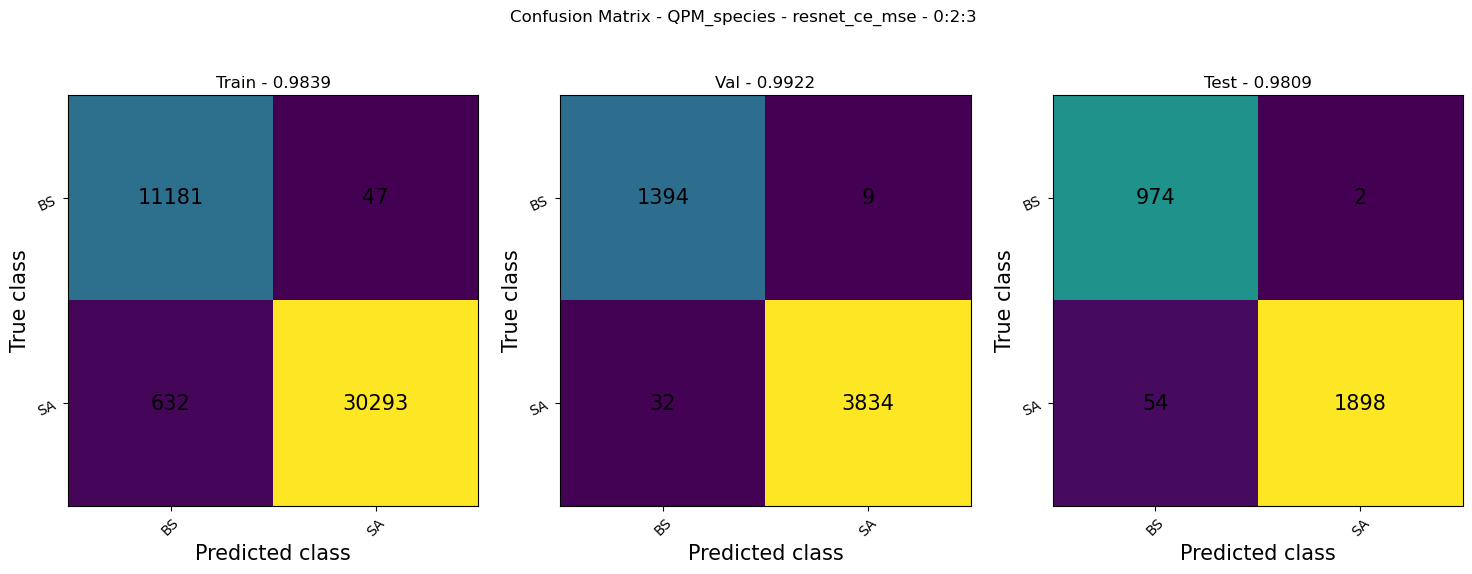

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

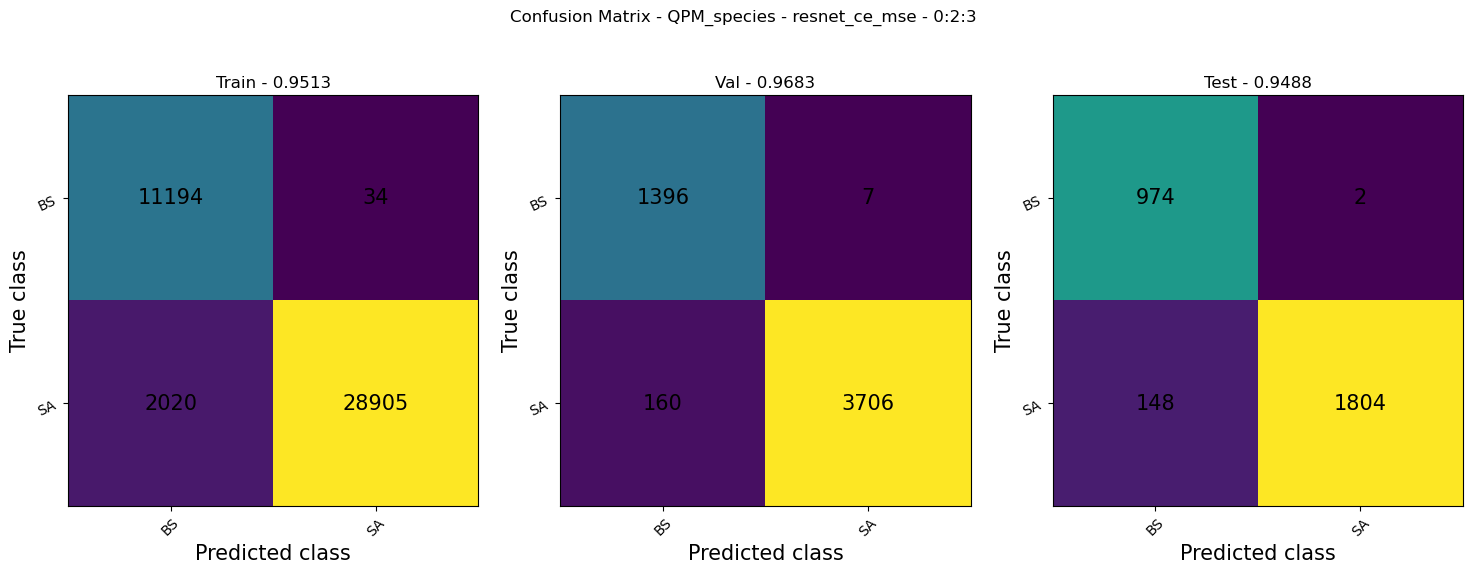

In [12]:
# compute test set accuracy - FPI
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(ftrain_acc=train_acc, fval_acc=val_acc, ftest_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [13]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2928, 2) (17568, 2)
(2928, 2) (17568, 2)


In [14]:
# create 2d embeddings - FPI
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2928, 2) (17568, 2)
(2928, 2) (17568, 2)


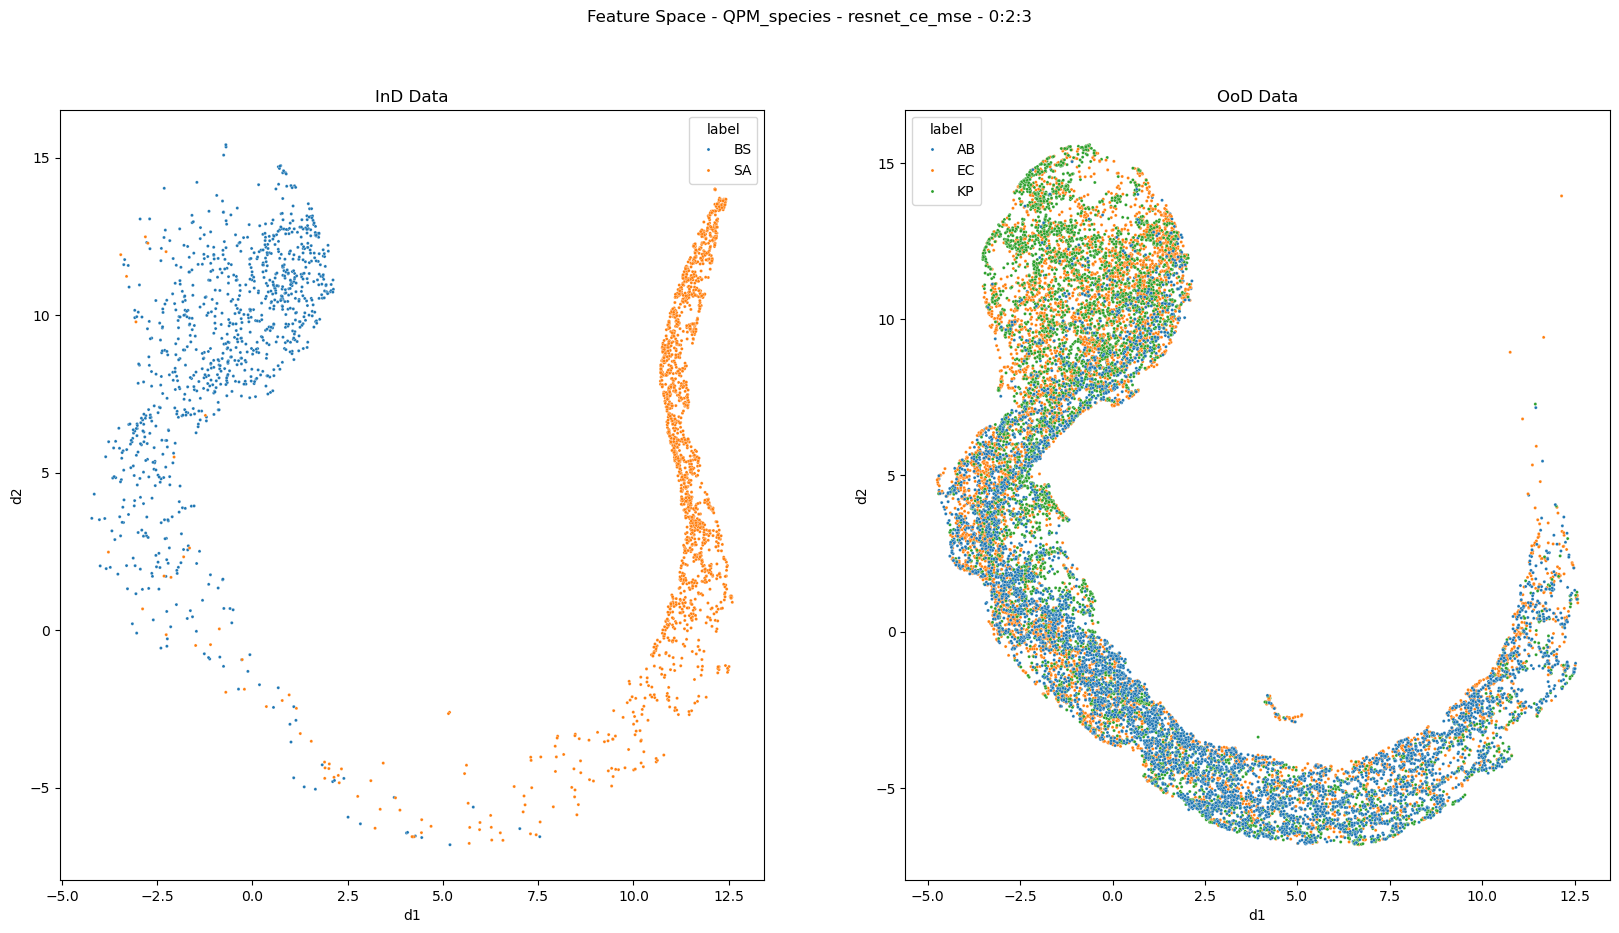

In [15]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

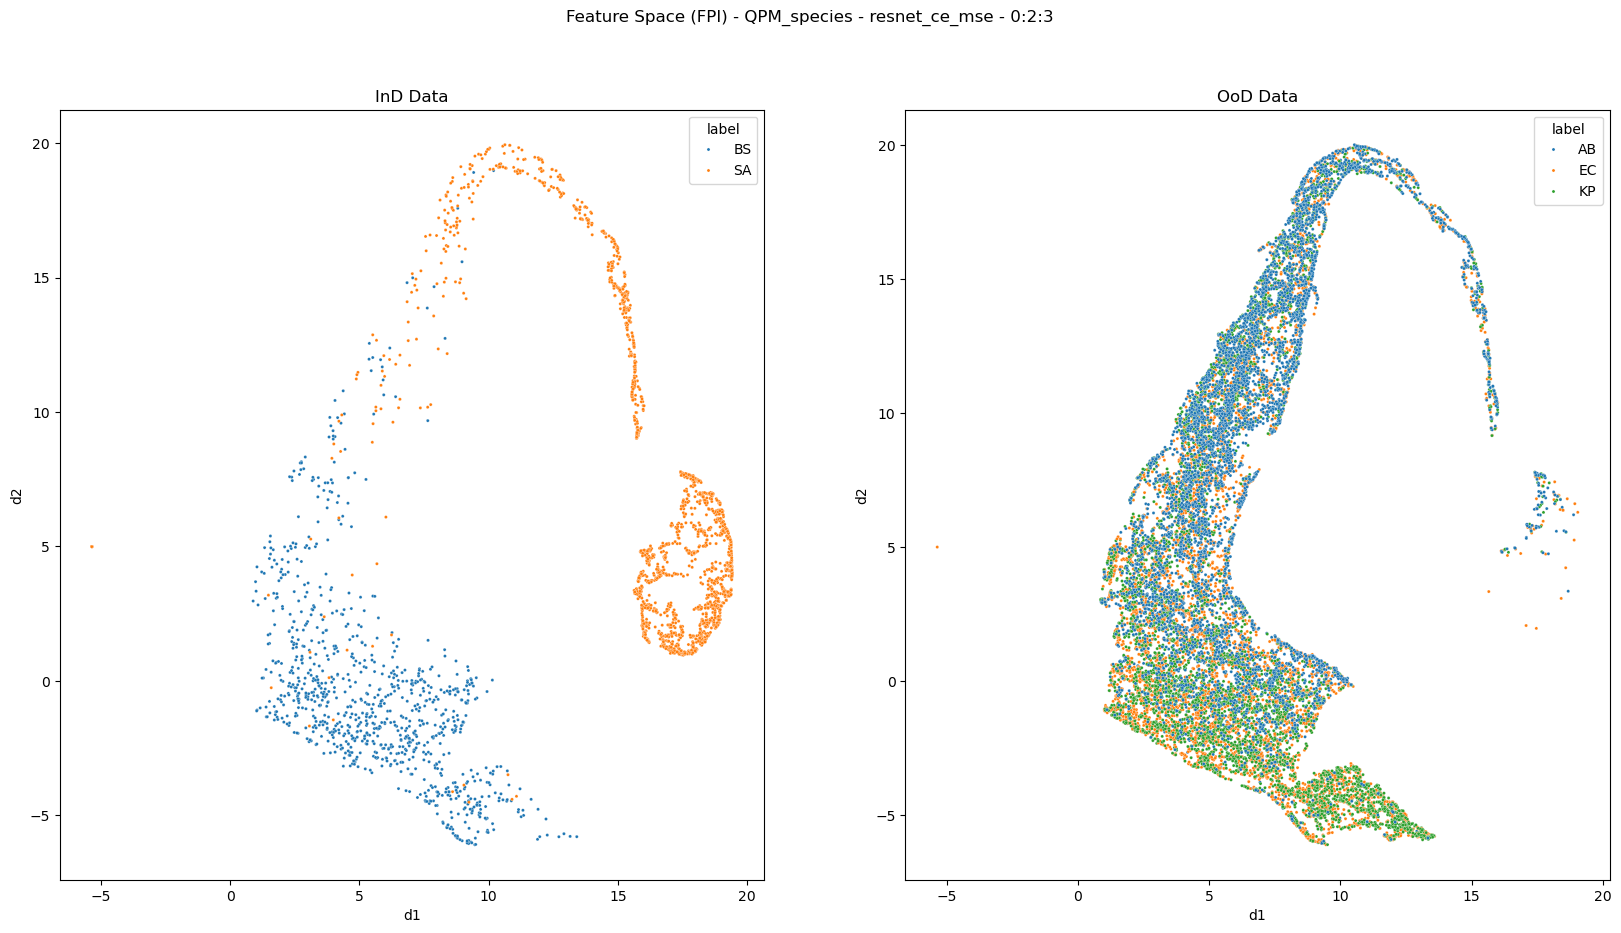

In [16]:
# plot feature space - FPI
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

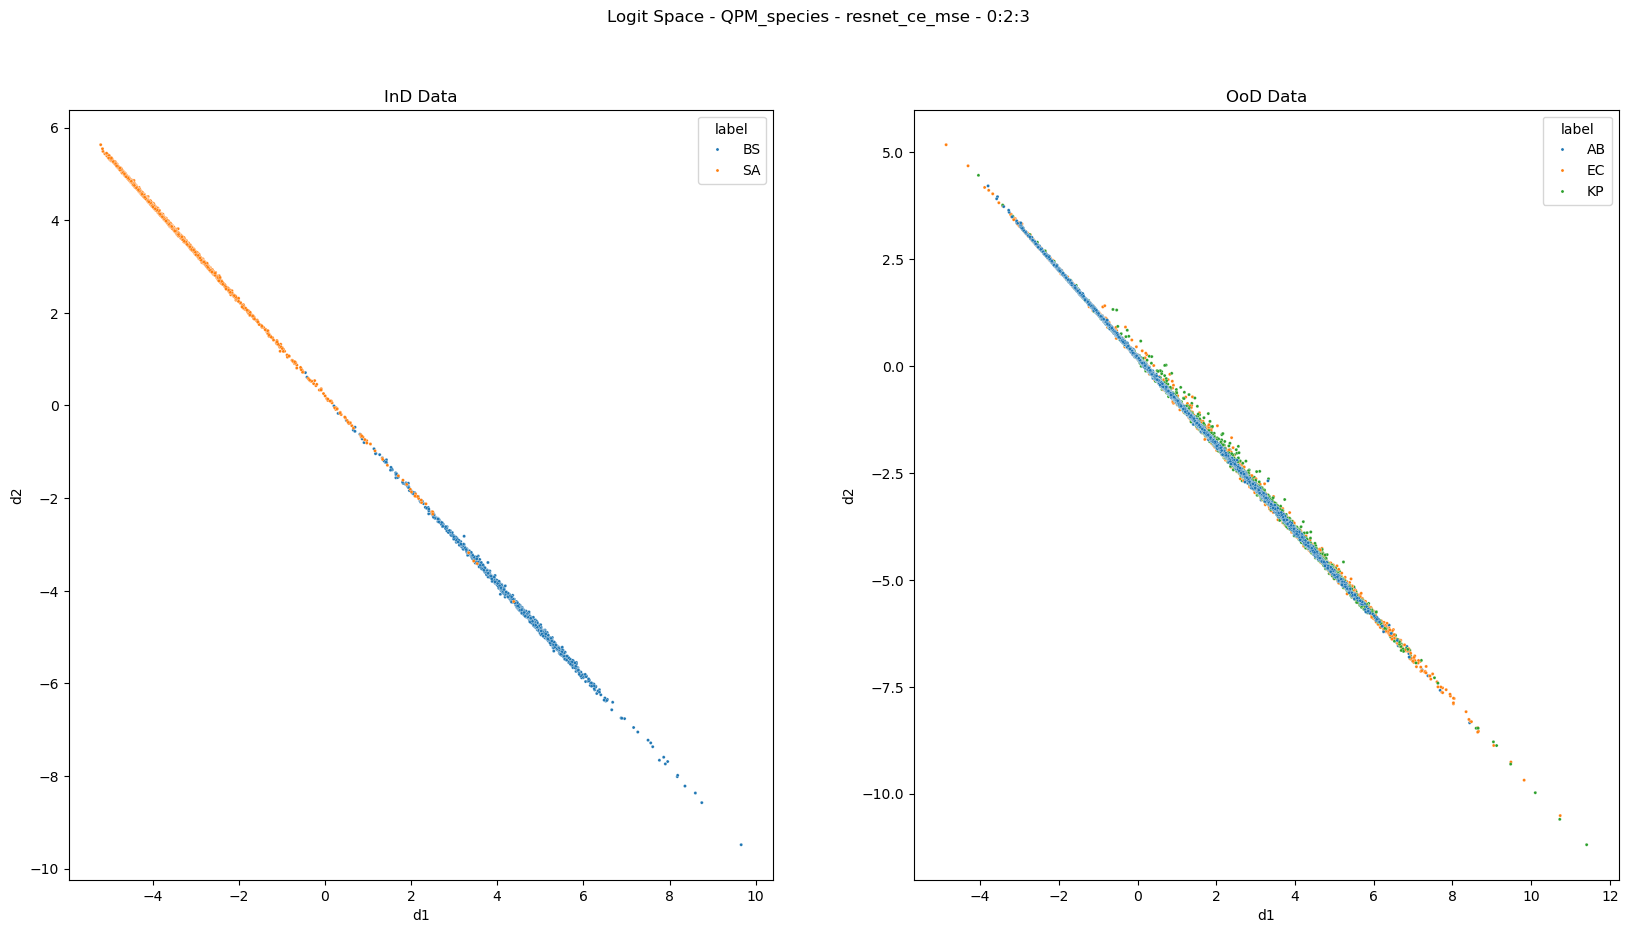

In [17]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

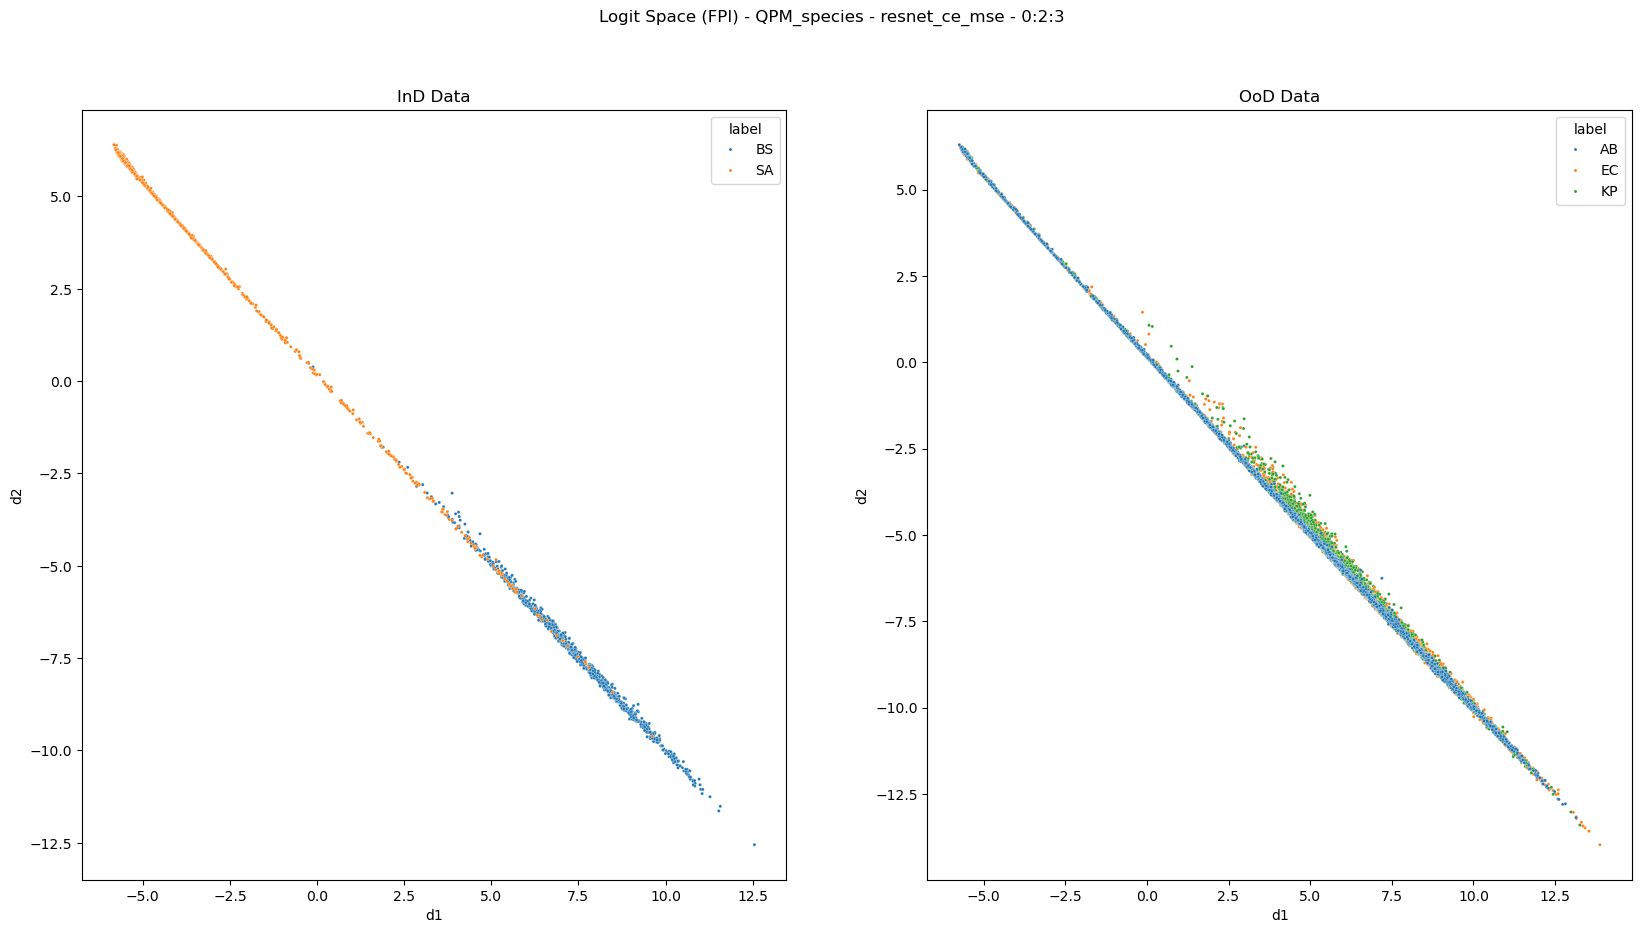

In [18]:
# plot logit space - FPI
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

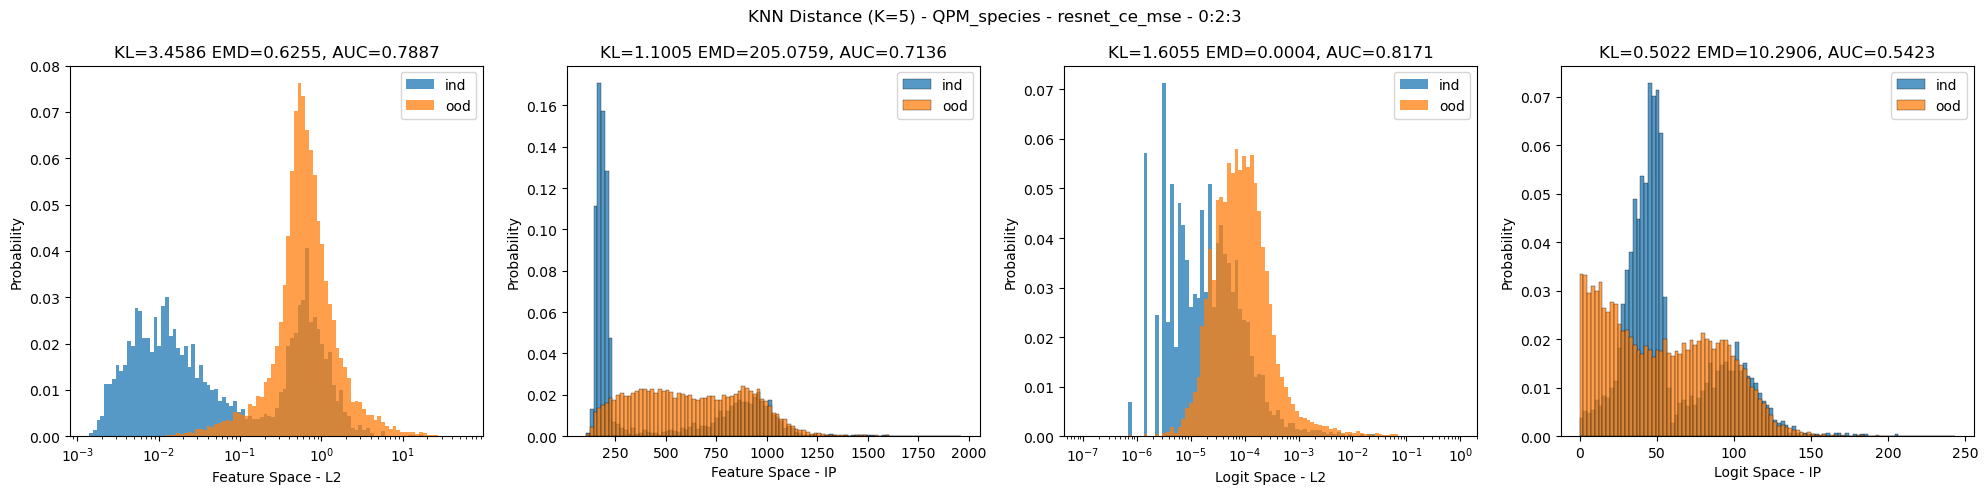

In [19]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats


fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

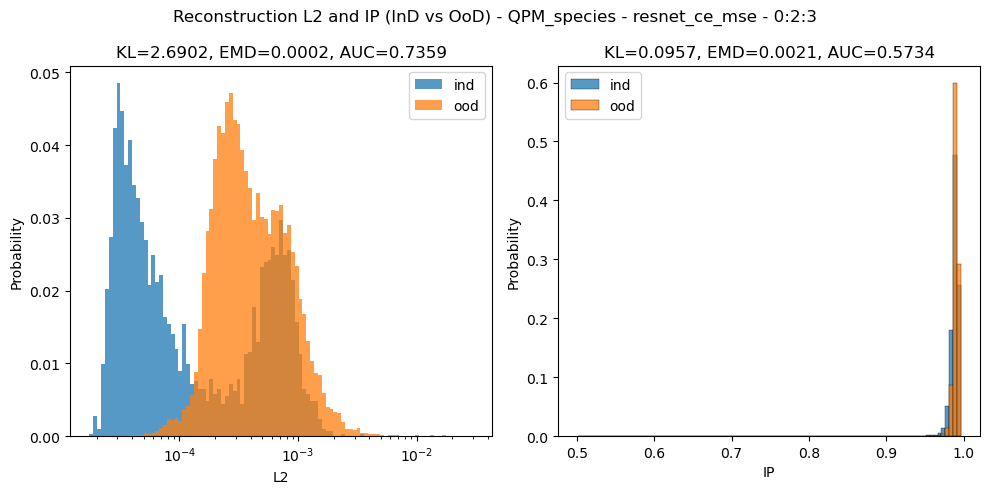

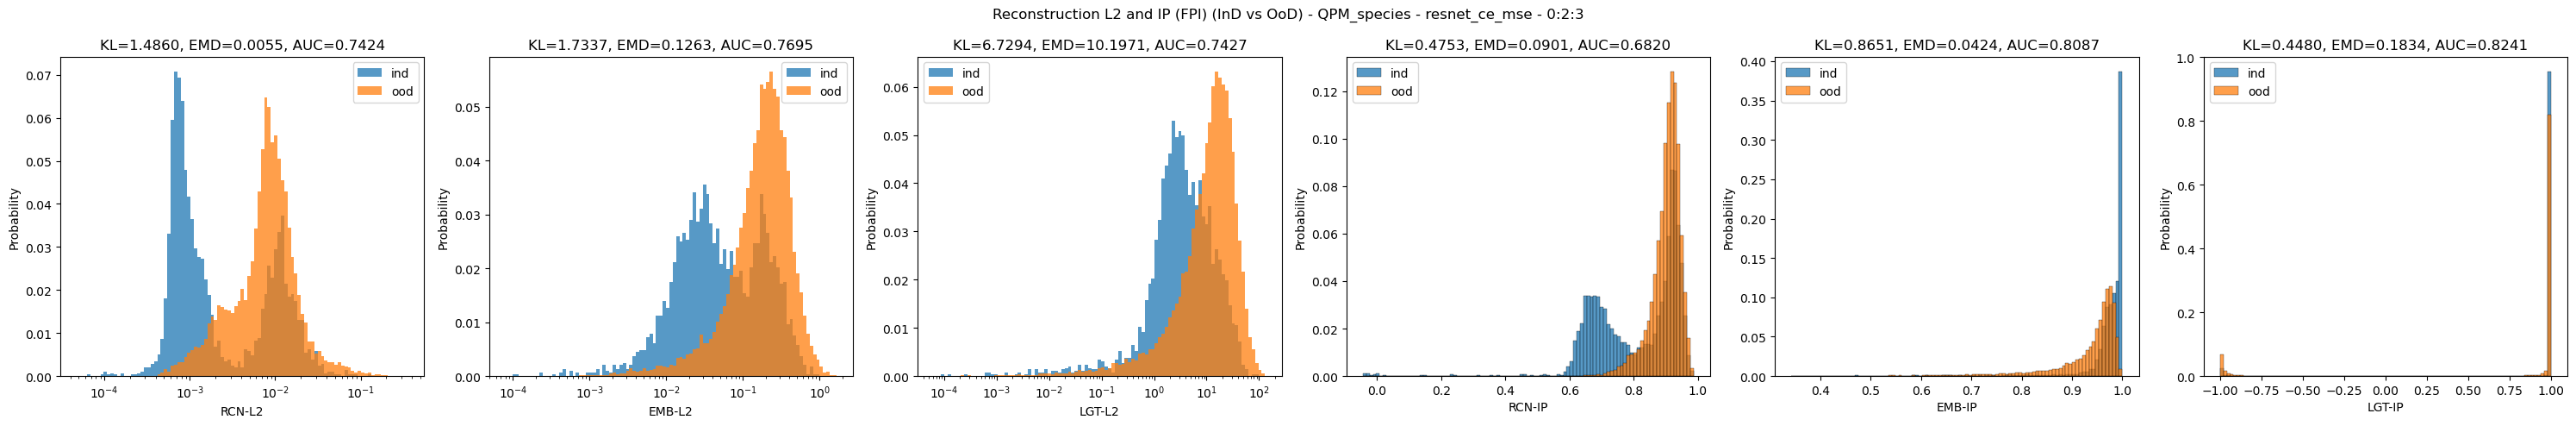

In [20]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# validation data
_val_inp = flatten(val_inp)
_val_rcn, _val_emb, _val_lgt = flatten(val_rcn), flatten(val_emb), flatten(val_lgt)
_val_rcn_fpi, _val_emb_fpi, _val_lgt_fpi = flatten(val_rcn_fpi), flatten(val_emb_fpi), flatten(val_lgt_fpi)
_val_inp_unit = unit(_val_inp)
_val_rcn_unit, _val_emb_unit, _val_lgt_unit = unit(_val_rcn), unit(_val_emb), unit(_val_lgt)
_val_rcn_fpi_unit, _val_emb_fpi_unit, _val_lgt_fpi_unit = unit(_val_rcn_fpi), unit(_val_emb_fpi), unit(_val_lgt_fpi)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)
val_rcn_l2_fpi = ((_val_inp - _val_rcn_fpi) ** 2).mean(-1)
val_emb_l2_fpi = ((_val_emb - _val_emb_fpi) ** 2).mean(-1)
val_lgt_l2_fpi = ((_val_lgt - _val_lgt_fpi) ** 2).mean(-1)
val_rcn_ip_fpi = (_val_inp_unit * _val_rcn_fpi_unit).sum(-1)
val_emb_ip_fpi = (_val_emb_unit * _val_emb_fpi_unit).sum(-1)
val_lgt_ip_fpi = (_val_lgt_unit * _val_lgt_fpi_unit).sum(-1)

# ind test data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # ood test data    
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))
run_stats["frcn_l2"] = plot_rcn(val_rcn_l2_fpi, ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
run_stats["femb_l2"] = plot_rcn(val_emb_l2_fpi, ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
run_stats["flgt_l2"] = plot_rcn(val_lgt_l2_fpi, ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
run_stats["frcn_ip"] = plot_rcn(val_rcn_ip_fpi, ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
run_stats["femb_ip"] = plot_rcn(val_emb_ip_fpi, ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
run_stats["flgt_ip"] = plot_rcn(val_lgt_ip_fpi, ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

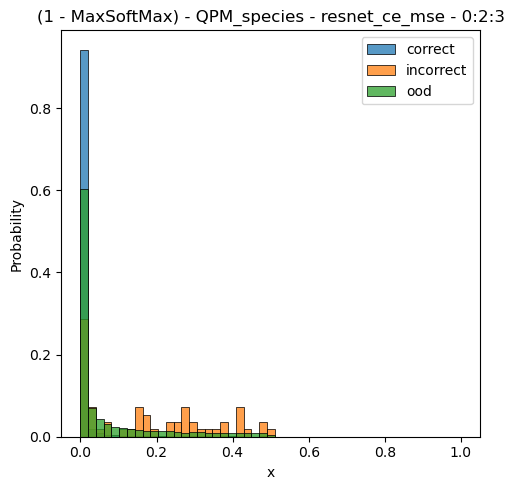

In [21]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

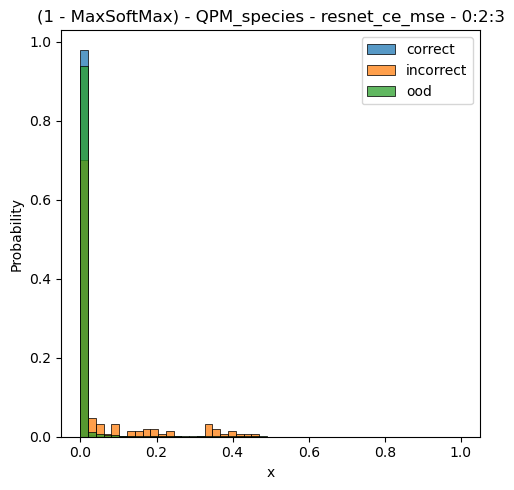

In [22]:
# plot (1 - maxsoftmax) distribution - FPI
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [23]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)